# Introduction

## 1. Importing Libraries

In [143]:
# General
import warnings
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.offline import init_notebook_mode
import cufflinks as cf

General set-up

In [144]:
%load_ext watermark
%watermark -i -v -u -co
init_notebook_mode(connected=True)
%matplotlib inline
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.4f}'.format)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-08-25T23:41:44.157652+08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.22.2

conda environment: data_analysis_31013



In [145]:
px.colors.cyclical.swatches()
px.colors.qualitative.swatches()
px.colors.sequential.swatches()

In [146]:
# Seeding random generator
np.random.seed(252)

## 2. Trip Distribution methods

### a. Growth Factor methods

#### i. Average Factor method

In [147]:
def afm(present_trips, future_trips, growth_rate, afm_iteration):
    
    afm_iteration = afm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate

    afm_growth_rate = np.zeros((growth_rate.shape[-2] * (afm_iteration + 1), growth_rate.shape[-1]))    # matrix for storing progression of growth rates, adding 1 in iteration to incorporate original data
    afm_array = np.zeros((present_trips.shape[-2] * (afm_iteration + 1), present_trips.shape[-1]))      # matrix for storing progression of present trips, adding 1 in iteration to incorporate original data
    afm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))     # dedicated mxn matrix to store trips that will be multiplied to averaged growth rate
    afm_recharging_growth_rate = np.zeros_like(afm_recharging_array, dtype=float)       # dedicated mxn matrix to store averaged growth rate

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):

            for k in range(growth_rate.shape[-1]):
                afm_growth_rate[i, k] = growth_rate[i, k]       # 0th index (1st level) of trip growth rate matrix
            afm_array[i, j] = present_trips[i, j]       # 0th index (1st level) of present trip matrix


    for t in range(afm_iteration):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_growth_rate[i, j] = (afm_growth_rate[(present_trips.shape[-2] * t) + i, 0] +
                                                    afm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * 0.5  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_array[i, j] = afm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced             
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = afm_recharging_array[i, j] * \
                                                                        afm_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration row of future trips in afm_array
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=1),
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))        
        new_recharging_growth_rate = future_trips / new_recharging_array_sum        
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                afm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration of growth rate in afm_growth_rate
    
    mock_convergence = np.ones((present_trips.shape[-2], afm_growth_rate.shape[-1]), dtype=float)       # base matrix for comparing convergence rate to 1 using 1 + nth iteration growth rate
    
    afm_convergence = afm_growth_rate[
        ((present_trips.shape[-2] * (afm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (afm_iteration + 1),
        0: afm_growth_rate.shape[-1]
        ]
    
    return np.amax(np.absolute(afm_convergence - mock_convergence)) * 100

##### Dedicated Convergence testing

In [148]:
def ded_test(dist_func, n_zones, n_iter, test_pre_mean, test_pre_var, **kwargs):
    np.random.seed(252)
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_type = kwargs.get('gm_type')

    if (factor_fut_mean != None) and (factor_fut_var != None):
        test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
        test_fut_var = test_pre_var * (1 + factor_fut_var)
    else:
        pass

    for i in n_zones:
        if (gm_imp_mean != None) and (gm_imp_var != None):
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        else:
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
            arr_present.append(mock_present.tolist())
            arr_future.append(mock_future.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
            growth_rate.append(mock_future / mock_total_present_trips)
    
    if dist_func == "AFM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "DM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FurM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "GMImp":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_imp(np.array(arr_total_present[i]), np.array(gm_imp_dist[i]), gm_type=gm_type, gm_iteration=j + 1)

    comp_df_method = []
    
    if dist_func == "AFM":
        comp_df_method.append(np.array(['Average Factor Method']* n_iter * len(n_zones)))
    elif dist_func == "DM":
        comp_df_method.append(np.array(['Detroit Method']* n_iter * len(n_zones)))
    elif dist_func == "FM":
        comp_df_method.append(np.array(['Fratar Method']* n_iter * len(n_zones)))
    elif dist_func == "FurM":
        comp_df_method.append(np.array(['Furness Method']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "ATT":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Attraction constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "GEN":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Generation constrained']* n_iter * len(n_zones)))

    comp_df_method = np.array(comp_df_method).flatten()
        
    comp_df_zones = []
    
    for i in (n_zones):
        mock = str(i)
        comp_df_zones.append(np.array([mock]*n_iter))
    
    comp_df_zones = np.array(comp_df_zones).flatten()

    comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(n_zones))
    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])
    
    sns.set_style('dark', {'axes.facecolor' : '#F0F8FF'})

    fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

    sns.lineplot(data=comparison_df, x='Iteration', y='Convergence', hue='Method', palette=['#1874CD'],
                 linewidth=1.2, markersize=0, style='Number of Zones')
    sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
    
    if dist_func == "AFM":
        comparison_df_plot.set_title(f'Average Factor Method'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nFuture Trips: Mean Increase = {factor_fut_mean}%, Variance Increase = {factor_fut_var}%',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    elif dist_func == "DM":
        comparison_df_plot.set_title(f'Detroit Method'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nFuture Trips: Mean Increase = {factor_fut_mean}%, Variance Increase = {factor_fut_var}%',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    elif dist_func == "FM":
        comparison_df_plot.set_title(f'Fratar Method'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nFuture Trips: Mean Increase = {factor_fut_mean}%, Variance Increase = {factor_fut_var}%',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    elif dist_func == "FurM":
        comparison_df_plot.set_title(f'Furness Method'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nFuture Trips: Mean Increase = {factor_fut_mean}%, Variance Increase = {factor_fut_var}%',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    elif dist_func == "GMImp" and gm_type == 'ATT':
        comparison_df_plot.set_title(f'Gravity Method (Impedance) - Attraction constrained'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nImpedance: Mean = {gm_imp_mean}, Variance = {gm_imp_var}',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    elif dist_func == "GMImp" and gm_type == 'GEN':
        comparison_df_plot.set_title(f'Gravity Method (Impedance) - Generation constrained'
                                     f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                     f'\nImpedance: Mean = {gm_imp_mean}, Variance = {gm_imp_var}',
                                     fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    
    comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
    comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
    comparison_df_plot.xaxis.set_major_formatter('{x:,.0f}')
    comparison_df_plot.yaxis.set_major_formatter('{x:,.0f}')
    # comparison_df_plot.locator_params(axis='x', nbins=np.round(n_iter/10))
    comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
    title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
    title_comparison_1_df_plot.set_family("Nirmala UI")
    title_comparison_1_df_plot.set_weight("bold")
    title_comparison_1_df_plot.set_size(10)
    plt.ylim(0,25)

    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    comp_df_method = []
    comp_df_zones = []

    fig.show()

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



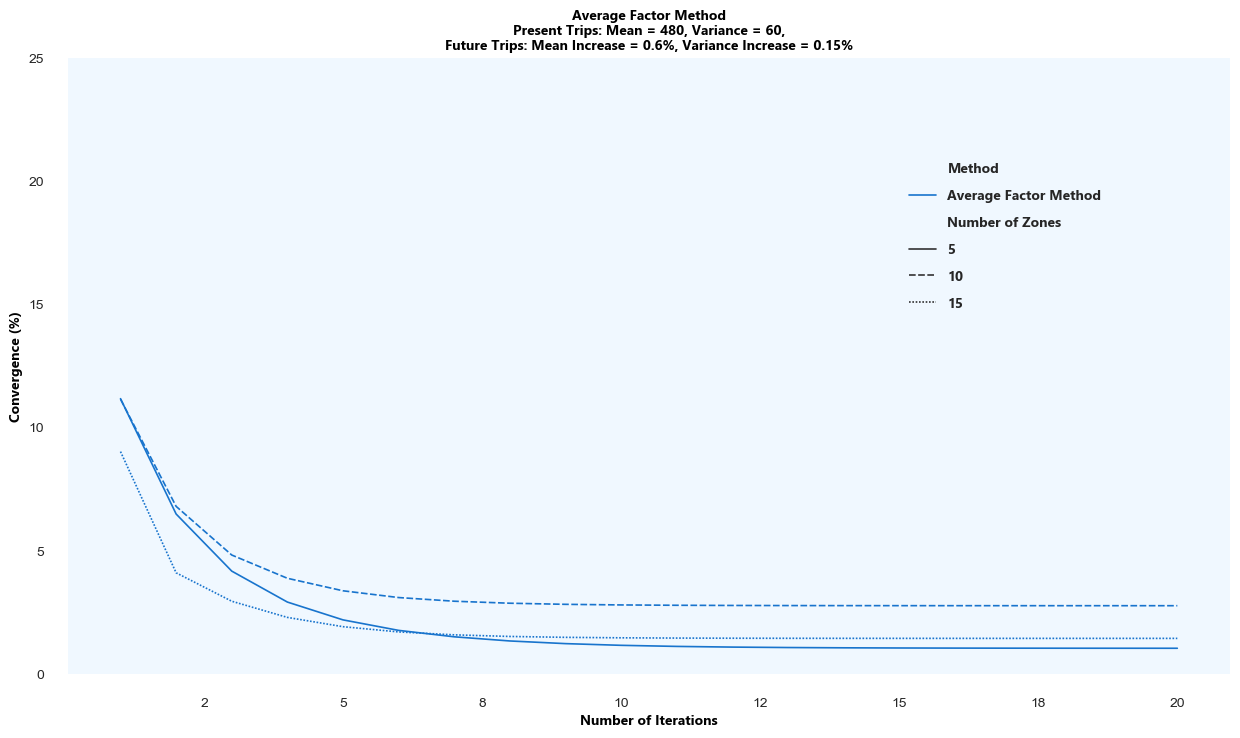

In [149]:
ded_test(dist_func='AFM', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=20)

#### ii. Detroit method

In [150]:
def dm(present_trips, future_trips, growth_rate, dm_iteration):
    
    dm_iteration = dm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    dm_growth_rate = np.zeros((growth_rate.shape[-2] * (dm_iteration + 2), growth_rate.shape[-1]))
    dm_array = np.zeros(((dm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_growth_rate = np.zeros_like(dm_recharging_array, dtype=float)

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                dm_growth_rate[i, k] = growth_rate[i, k]
            dm_array[i, j] = present_trips[i, j]
    
    for t in range(dm_iteration):
        current_recharging_array_sum = dm_array[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0 : (present_trips.shape[-1] + 1)
            ].sum(axis=1).sum(axis=0)
        current_total_growth_rate = (future_trips.sum(axis=0)[0])/current_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_growth_rate[i, j] = (dm_growth_rate[(present_trips.shape[-2] * t) + i, 0] \
                                                   * dm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) \
                                                    * (1/current_total_growth_rate)    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_array[i, j] = dm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = dm_recharging_array[i, j] * dm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=1),
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                dm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], dm_growth_rate.shape[-1]), dtype=float)
    
    dm_convergence = dm_growth_rate[((present_trips.shape[-2] * (dm_iteration + 1)) - present_trips.shape[-2]):
                                         present_trips.shape[-2] * (dm_iteration + 1), 0: dm_growth_rate.shape[-1]]
    
    return np.amax(np.absolute(dm_convergence - mock_convergence)) * 100

##### ii.a. Dedicated Convergence testing

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



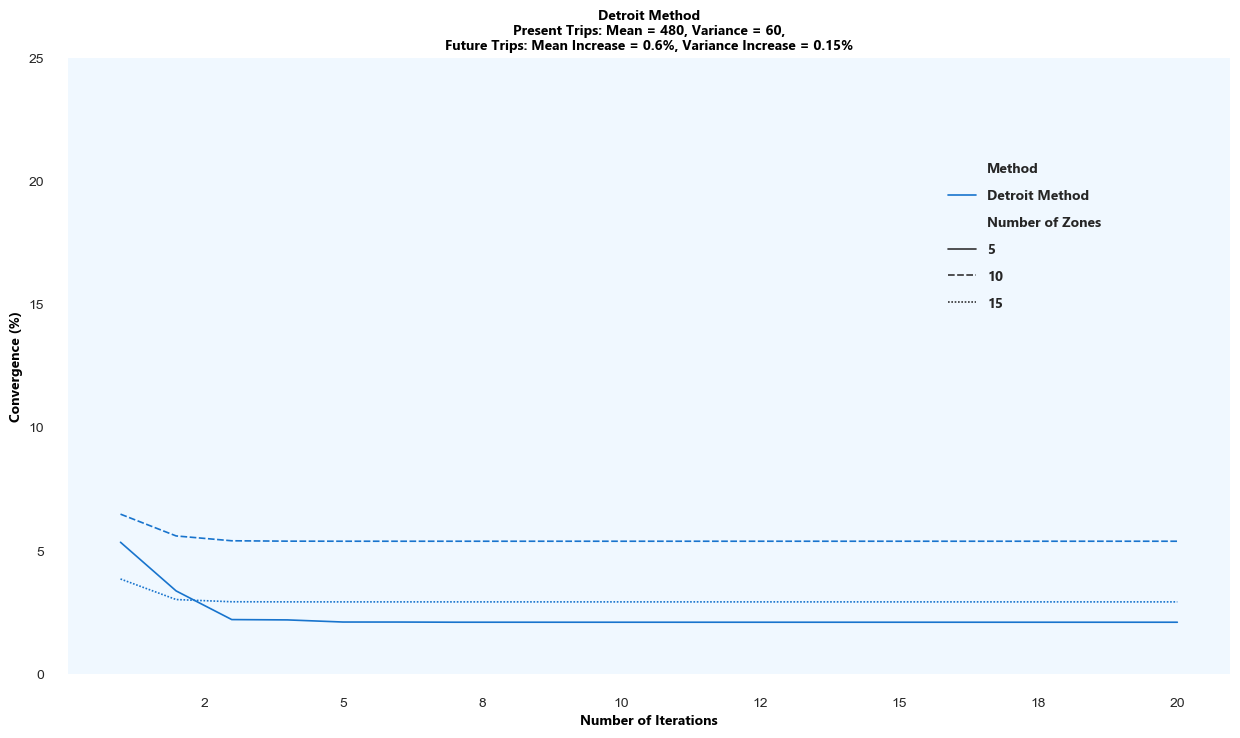

In [151]:
ded_test(dist_func='DM', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=20)

#### iii. Fratar method

In [152]:
def fm(present_trips, future_trips, growth_rate, fm_iteration):

    fm_iteration = fm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fm_growth_rate = np.zeros((growth_rate.shape[-2] * (fm_iteration + 2), growth_rate.shape[-1]))
    fm_array = np.zeros(((fm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_growth_rate = np.zeros_like(fm_recharging_array, dtype=float)
    fm_trip_growth_rate_divisor = np.zeros_like(present_trips, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fm_growth_rate[i, k] = growth_rate[i, k]
            fm_array[i, j] = present_trips[i, j]
    
    for t in range((fm_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_array[i, j] = fm_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fm_current_growth_rate = fm_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        trips_attraction_growth_rate_sum = np.matmul(fm_recharging_array, fm_current_growth_rate)
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_trip_growth_rate_divisor[i, j] = (trips_attraction_growth_rate_sum[:, 1])[i]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_growth_rate[i, j] = (fm_growth_rate[(present_trips.shape[-2] * t) + i, 0] *      # not advanced
                                                   fm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * \
                                                  (fm_recharging_array.sum(axis=1)[i]) / fm_trip_growth_rate_divisor[i, 1]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fm_recharging_array[i, j] * fm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fm_growth_rate.shape[-1]), dtype=float)
    
    fm_convergence = fm_growth_rate[
        ((present_trips.shape[-2] * (fm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fm_iteration + 1),
        0: fm_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fm_convergence - mock_convergence)) * 100

##### Dedicated Convergence testing

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



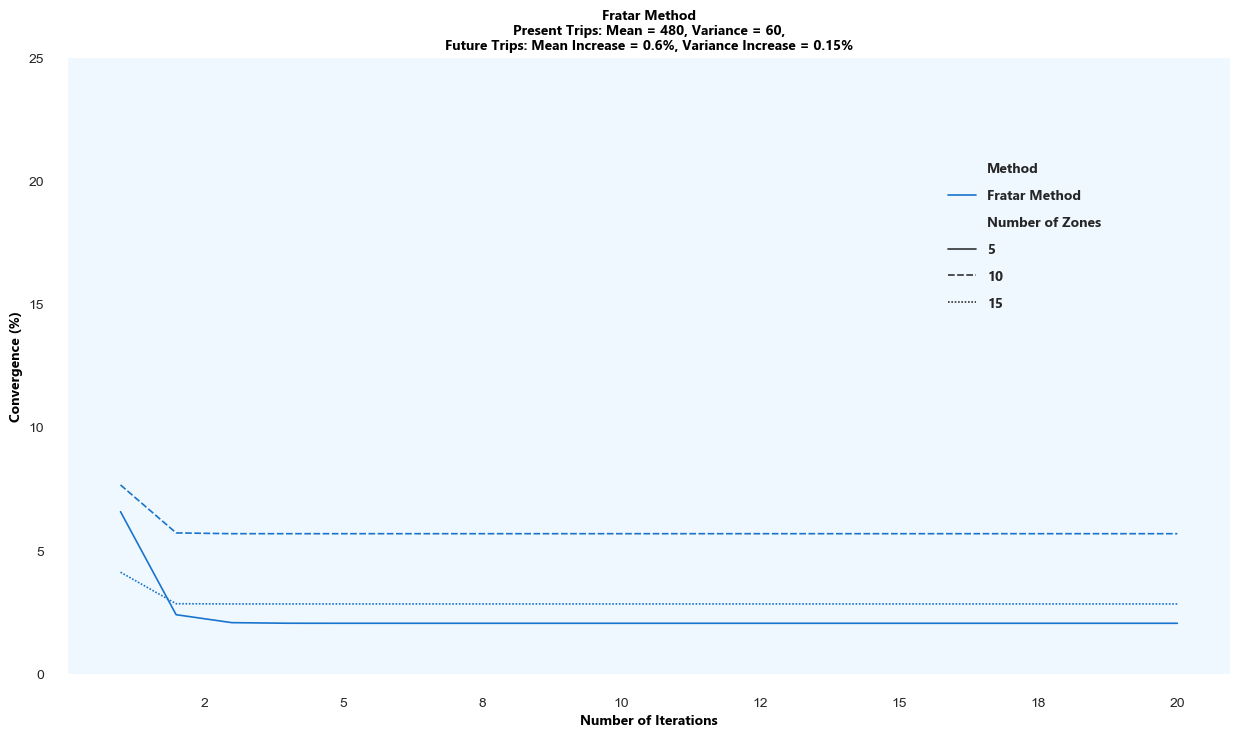

In [153]:
ded_test(dist_func='FM', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=20)

#### iv. Furness method

In [154]:
def fur(present_trips, future_trips, growth_rate, fur_iteration):

    fur_iteration = fur_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fur_growth_rate = np.zeros((growth_rate.shape[-2] * (fur_iteration + 2), growth_rate.shape[-1]))
    fur_array = np.zeros(((fur_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_growth_rate = np.zeros_like(fur_recharging_array, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fur_growth_rate[i, k] = growth_rate[i, k]
            fur_array[i, j] = present_trips[i, j]
    
    for t in range((fur_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fur_recharging_array[i, j] = fur_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fur_current_growth_rate = fur_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        if divmod(t, 2)[-1] == 0:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 0]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i]      # advanced
        else:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 1]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[j]      # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fur_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fur_growth_rate.shape[-1]), dtype=float)
    
    fur_convergence = fur_growth_rate[
        ((present_trips.shape[-2] * (fur_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fur_iteration + 1),
        0: fur_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fur_convergence - mock_convergence)) * 100

##### Dedicated Convergence testing

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



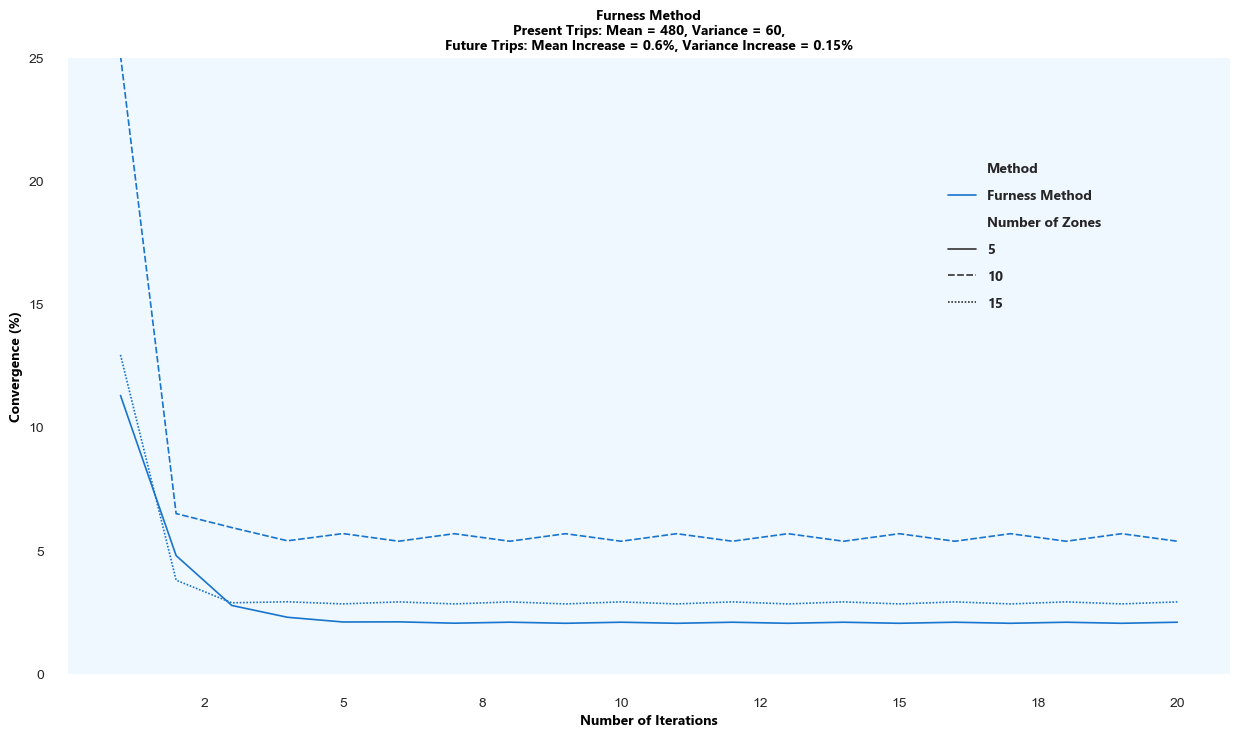

In [155]:
ded_test(dist_func='FurM', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=20)

### b. Synthetic  Methods

#### b.i. Gravity method (Impedance)

In [156]:
def gm_imp(base_trip_sum, gm_imp_dist, gm_type, gm_iteration):

    gm_iteration = gm_iteration
    base_trip_sum = base_trip_sum
    gm_imp_dist = gm_imp_dist
    
    gm_arr_sum = np.zeros(((gm_iteration + 2) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))
    gm_trip_imp_prod = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_recharging_factor = np.zeros_like(gm_trip_imp_prod, dtype=float)
    gm_arr = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_trip_sum_factor = np.zeros(((gm_iteration + 1) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))

    for i in range(base_trip_sum.shape[-2]):
        for j in range(base_trip_sum.shape[-1]):
            gm_arr_sum[i, j] = base_trip_sum[i, j]

    if gm_type == 'GEN':
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 1]
    else:
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 0]
    
    for t in range((gm_iteration) + 1):
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, :].sum()
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] \
                                                                                / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) : (gm_imp_dist.shape[-2] * (t + 1)) , j].sum()
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + i, 0]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + j, 1]
        mock_arr_sum = np.transpose(np.vstack(
            (gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=1),
            gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=0)
            )
        ))        
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j] = mock_arr_sum[i, j]
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_trip_sum_factor[(base_trip_sum.shape[-2] * t) + i, j] = gm_arr_sum[(base_trip_sum.shape[-2] * 0) + i, j] / gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j]        # not advanced
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + j, 1]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + i, 0]
                        
    mock_convergence = np.ones((gm_imp_dist.shape[-2], gm_trip_sum_factor.shape[-1]), dtype=float)
    
    gm_imp_convergence = gm_trip_sum_factor[
        ((gm_imp_dist.shape[-2] * gm_iteration) - gm_imp_dist.shape[-2]): gm_imp_dist.shape[-2] * gm_iteration,
        :
    ]
    
    return np.amax(np.absolute(gm_imp_convergence - mock_convergence)) * 100

In [157]:
base_trip_sum = np.transpose(np.array([[1880, 3024, 2043, 1516, 1810, 3216, 1015],
                         [1456, 441, 1056, 6960, 121, 2845, 1648]]))
gm_imp_dist = np.array([[375.75, 6532.47, 6766.26, 2567.14, 751.50, 3313.36, 3044.69],
                       [6532.47, 2022.25, 4585.92, 4274.36, 7209.27, 4044.49, 4367.61],
                       [6766.26, 4585.92, 1726.45, 4625.25, 7304.25, 3452.89, 4874.30],
                       [2567.14, 4274.36, 4625.25, 586.18, 3243.95, 1172.36, 1436.81],
                       [751.50, 7209.27, 7304.25, 3243.95, 375.75, 3851.36, 3721.49],
                       [3313.36, 4044.49, 3452.89, 1172.36, 3851.36, 586.18, 2510.96],
                       [3044.69, 4367.61, 4874.30, 1436.81, 3721.49, 2510.96, 718.40]])

##### Dedicated Convergence testing

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



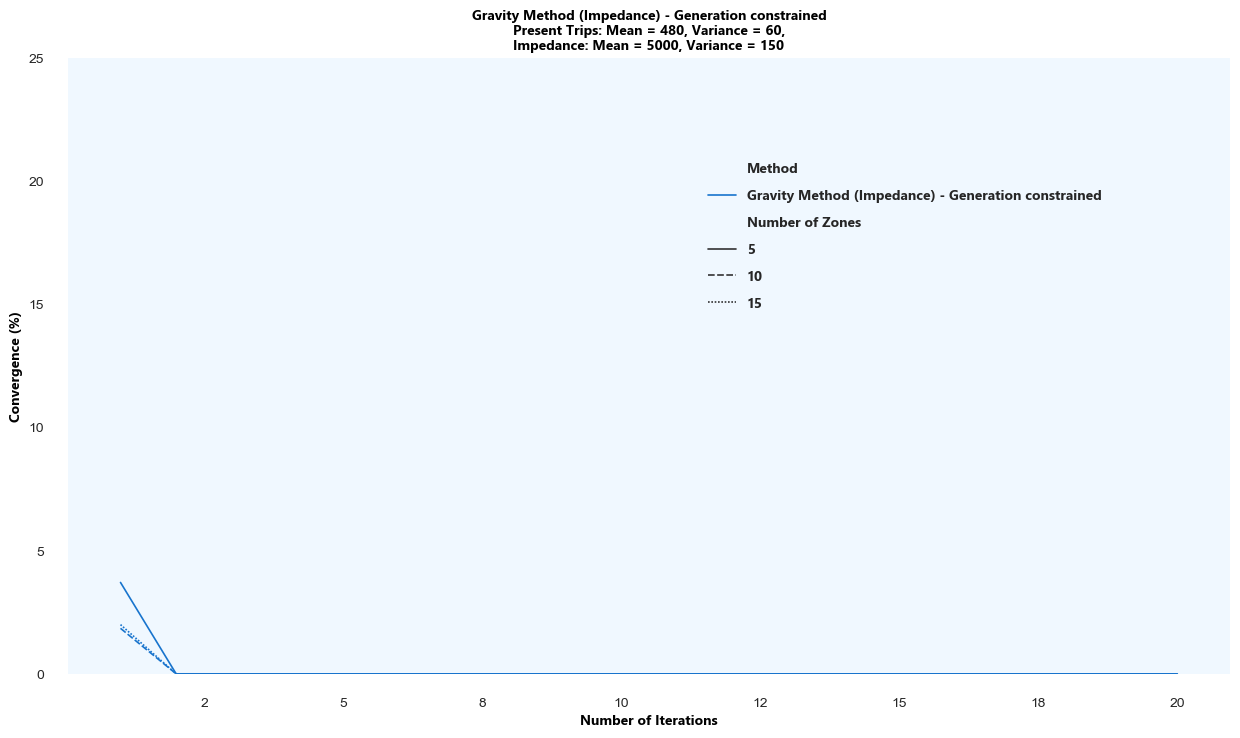

In [158]:
ded_test(dist_func='GMImp', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, gm_imp_mean=5000, gm_imp_var=150, gm_type='GEN',n_iter=20)

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\892888535.py:160: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



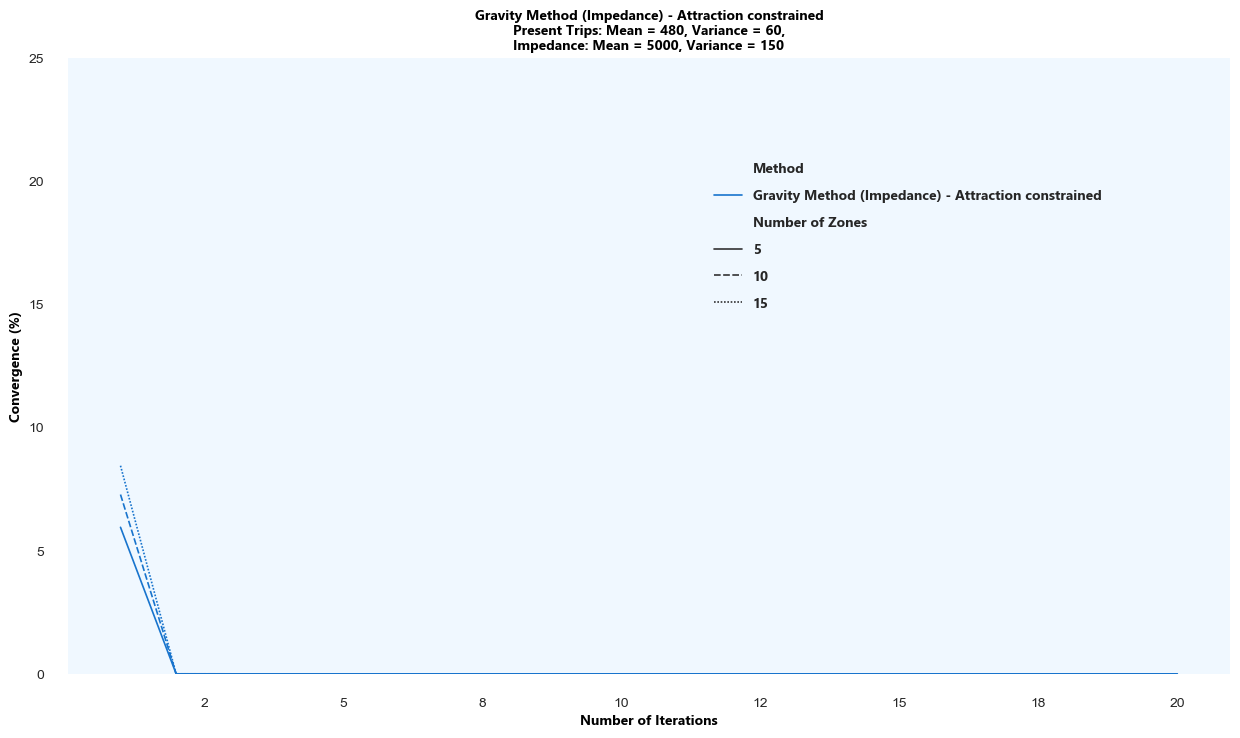

In [159]:
ded_test(dist_func='GMImp', n_zones=[5, 10, 15], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, 
         gm_imp_mean=5000, gm_imp_var=150, gm_type='ATT',n_iter=20)

## 3. Convergence testing

### a. Based on single PDF in creating trip matrices

In [160]:
def conv_test(dist_func_arr, n_zones, test_pre_mean, test_pre_var, factor_fut_mean, factor_fut_var, gm_imp_mean, gm_imp_var, gm_type, n_iter):
    np.random.seed(252)
    test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
    test_fut_var = test_pre_var * (1 + factor_fut_var)
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []

    for i in n_zones:
        mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
        np.fill_diagonal(mock_present, 0)
        mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
        arr_present.append(mock_present.tolist())
        arr_future.append(mock_future.tolist())
        mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
        arr_total_present.append(mock_total_present_trips.tolist())
        growth_rate.append(mock_future / mock_total_present_trips)
        mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
        gm_imp_dist.append(mock_imp_dist.tolist())
    
    conv_arr = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
    comp_df_method = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).astype('object').flatten()
    comp_df_zones = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
    comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr)*len(n_zones))

    for n_method in range(len(dist_func_arr)):
        if dist_func_arr[n_method] == 'AFM':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Average Factor'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
        elif dist_func_arr[n_method] == 'DM':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Detroit'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
        elif dist_func_arr[n_method] == 'FM':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Fratar'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
        elif dist_func_arr[n_method] == 'FurM':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Furness'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
        elif dist_func_arr[n_method] == 'GMImp' and gm_type == 'GEN':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = gm_imp(np.array(arr_total_present[i]), np.array(gm_imp_dist[i]), gm_type=gm_type, gm_iteration=j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Gravity Method (Impedance) - Generation constrained'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
        elif dist_func_arr[n_method] == 'GMImp' and gm_type == 'ATT':
            for i in range(len(n_zones)):
                for j in range(n_iter):
                    conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = gm_imp(np.array(arr_total_present[i]), np.array(gm_imp_dist[i]), gm_type=gm_type, gm_iteration=j + 1)
                    comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Gravity Method (Impedance) - Attraction constrained'
                    comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]    
    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])
    
    sns.set_style('dark', {'axes.facecolor' : '#F0F8FF'})

    fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

    sns.lineplot(data=comparison_df, x='Iteration', y='Convergence', hue='Method',
                 linewidth=1.75, markersize=0, style='Number of Zones', palette='tab10')
    sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
    
    comparison_df_plot.set_title(f'Trip Distribution Methods'
                                 f'\nPresent Trips: Mean = {test_pre_mean}, Variance = {test_pre_var},'
                                 f'\nFuture Trips: Mean Increase = {factor_fut_mean}%, Variance Increase = {factor_fut_var}%,'
                                 f'\nImpedance: Mean = {gm_imp_mean}, Variance = {gm_imp_var}',
                                 fontdict={'font': 'Nirmala UI', 'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    
    comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
    comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
    comparison_df_plot.xaxis.set_major_formatter('{x:,.0f}')
    comparison_df_plot.yaxis.set_major_formatter('{x:,.0f}')
    # comparison_df_plot.locator_params(axis='x', nbins=np.round(n_iter/10))
    comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
    title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
    title_comparison_1_df_plot.set_family("Nirmala UI")
    title_comparison_1_df_plot.set_weight("bold")
    title_comparison_1_df_plot.set_size(10)
    plt.ylim(0,25)
    fig.show()

C:\Users\imgle\AppData\Local\Temp\ipykernel_10308\3708161941.py:101: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



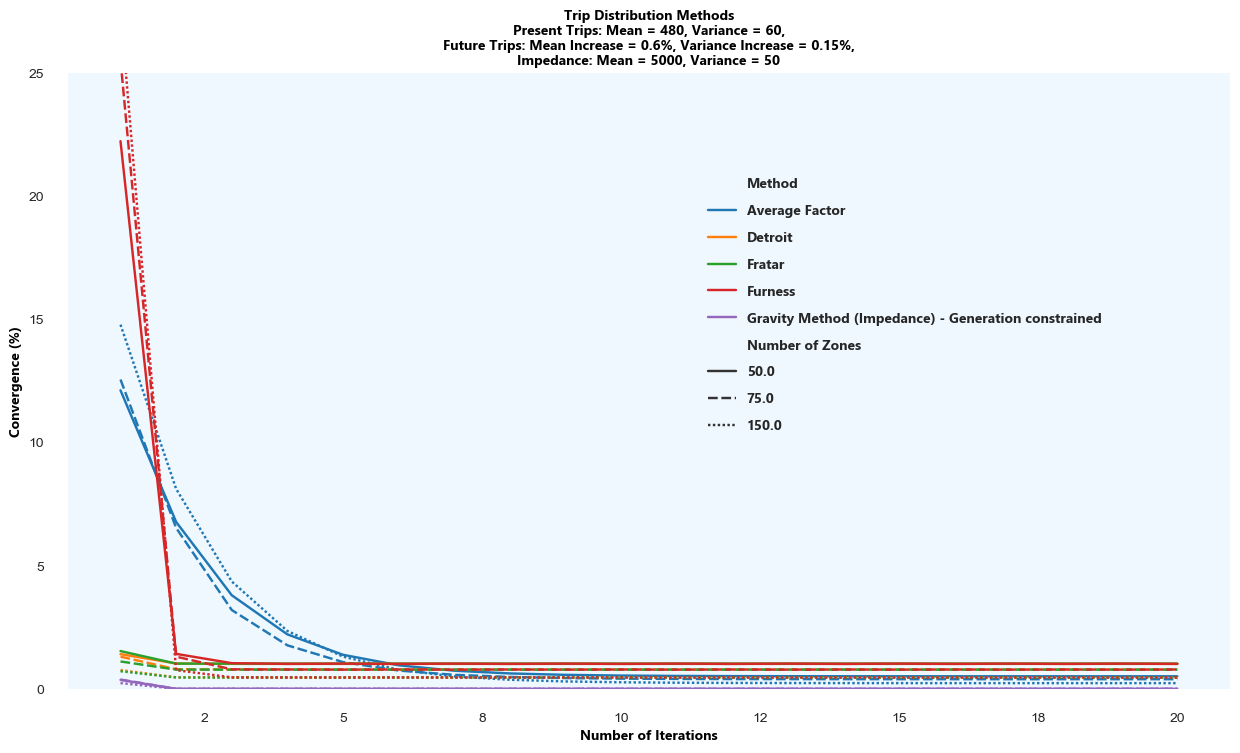

In [161]:
conv_test(dist_func_arr=['AFM', 'DM', 'FM', 'FurM', 'GMImp'], n_zones=[50,75,150], test_pre_mean=480, test_pre_var=60,
          factor_fut_mean=0.6, factor_fut_var=0.15, gm_imp_mean=5000, gm_imp_var=50, gm_type="GEN", n_iter=20)